In [16]:
import tensorflow as tf
from tensorflow import keras
import theano.tensor as T
import pymc3 as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tfmodel = keras.models.load_model('../test_grid_model.h5')

In [3]:
tfmodel.summary()

Model: "test_grid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
outputs (Dense)              (None, 3)                 33        
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [4]:
weights_list = tfmodel.get_weights()

In [5]:
def nn(input):
    nh_layers = int(len(weights_list) / 2 - 2)
    xx = T.nnet.elu(pm.math.dot(input, weights_list[0]) + weights_list[1])
    for hl in range(1, 1+nh_layers):
        xx = T.nnet.elu(pm.math.dot(xx, weights_list[hl * 2]) + weights_list[hl * 2 + 1])
    xx = pm.math.dot(xx, weights_list[-2]) + weights_list[-1]
    return 10**(xx)

In [6]:
params = ['star_age', 'initial_mass']
obs = ['radius', 'effective_T', 'delta_nu']

In [7]:
nn([np.log10(4.5), np.log10(1.0)]).eval()

array([1.14267237e+00, 6.08204420e+03, 1.13291452e+02])

In [48]:
Nstars = 100
ages = np.random.rand(Nstars) * 3.0 + 2.0
masses = np.random.randn(Nstars) * 0.05 + 1.0
inputs = np.array([ages , masses]).T
outputs = nn(inputs).eval()

In [49]:
obs_unc = np.array([[0.01, 70.0, 1.0] for n in range(Nstars)])
obs_ = outputs + np.random.randn(*outputs.shape) * obs_unc
print(obs_.shape)

(100, 3)


In [50]:
model = pm.Model()

with model:
    mass = pm.Normal('mass', 1.0, 0.2, shape=Nstars)
    age = pm.Normal('age', 4.5, 3.0, shape=Nstars)
    
    slist = [[age[m], mass[m]] for m in range(Nstars)]
    obs_prop = pm.Deterministic('obs_prop', nn(T.stacklists(slist)))
    
    like = pm.Normal('like', obs_prop, obs_unc, observed=obs_)

In [51]:
inits = ['adapt_diag']
start = {'mass': [1.0 for n in range(Nstars)], 'age': [4.5 for n in range(Nstars)]}

with model:
    trace = pm.sample(tune=1000, init=inits[0], start=start, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, mass]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1469 seconds.
The acceptance probability does not match the target. It is 0.9609807413214762, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9642021629236762, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8249270342400491, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [52]:
pm.traceplot(trace);

/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1469d2d08> (for post_execute):


KeyboardInterrupt: 

In [53]:
pm.summary(trace)

/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mass[0],0.886,0.004,0.880,0.893,0.000,0.000,2670.0,2670.0,2696.0,2307.0,1.00
mass[1],1.016,0.003,1.010,1.021,0.000,0.000,3374.0,3373.0,3378.0,3051.0,1.00
mass[2],0.988,0.002,0.985,0.992,0.000,0.000,3340.0,3340.0,3328.0,3067.0,1.00
mass[3],1.030,0.002,1.026,1.034,0.000,0.000,722.0,722.0,747.0,616.0,1.01
mass[4],1.062,0.002,1.058,1.067,0.000,0.000,4421.0,4418.0,4436.0,2478.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
"obs_prop[98,1]",240.726,1.197,238.644,243.135,0.020,0.014,3561.0,3561.0,3567.0,2850.0,1.00
"obs_prop[98,2]",175.100,1.004,173.263,177.044,0.016,0.011,3851.0,3844.0,3862.0,2733.0,1.00
"obs_prop[99,0]",3.496,0.010,3.478,3.514,0.000,0.000,4438.0,4438.0,4449.0,2773.0,1.00
"obs_prop[99,1]",607.709,3.815,600.330,614.667,0.057,0.041,4434.0,4434.0,4443.0,3217.0,1.00


0.8854713637213074 0.8863163319016962
1.0113508843889631 1.0155600589024991
0.9857419977111457 0.9880037001243417
1.0308467854187335 1.029933079239559
1.061011999798696 1.0622117868494918
1.026710836358293 1.022141001314571
1.0340358006484658 1.0365282318702533
1.0612189132837488 1.066674634003696
1.034549670565711 1.0332887409205898
1.0779111159867203 1.0811916051523836
0.9735174327021465 0.9741601004317944
1.027095100381936 1.0289793835198118
1.072446863755791 1.0516799968603667
1.0532849209065096 1.04124524065099
1.0239524522571288 1.0251090170113708
1.0552836323907255 1.0672956138637437
1.0948209008299572 1.0950087752676292
1.0370355505562416 1.0273230803080096
0.9649869883051564 0.9702671599289606
1.0493408042157681 1.0466092558838034
0.9714458054570316 0.9724074793496713
1.1233504466901598 1.1220312173918823
0.9459664760407563 0.944566680841645
0.9213271477631911 0.9180570053077115
0.9988603105332292 0.9999673176078647
1.0306066440607722 1.0233869093490393
1.0285116332061133 1.02

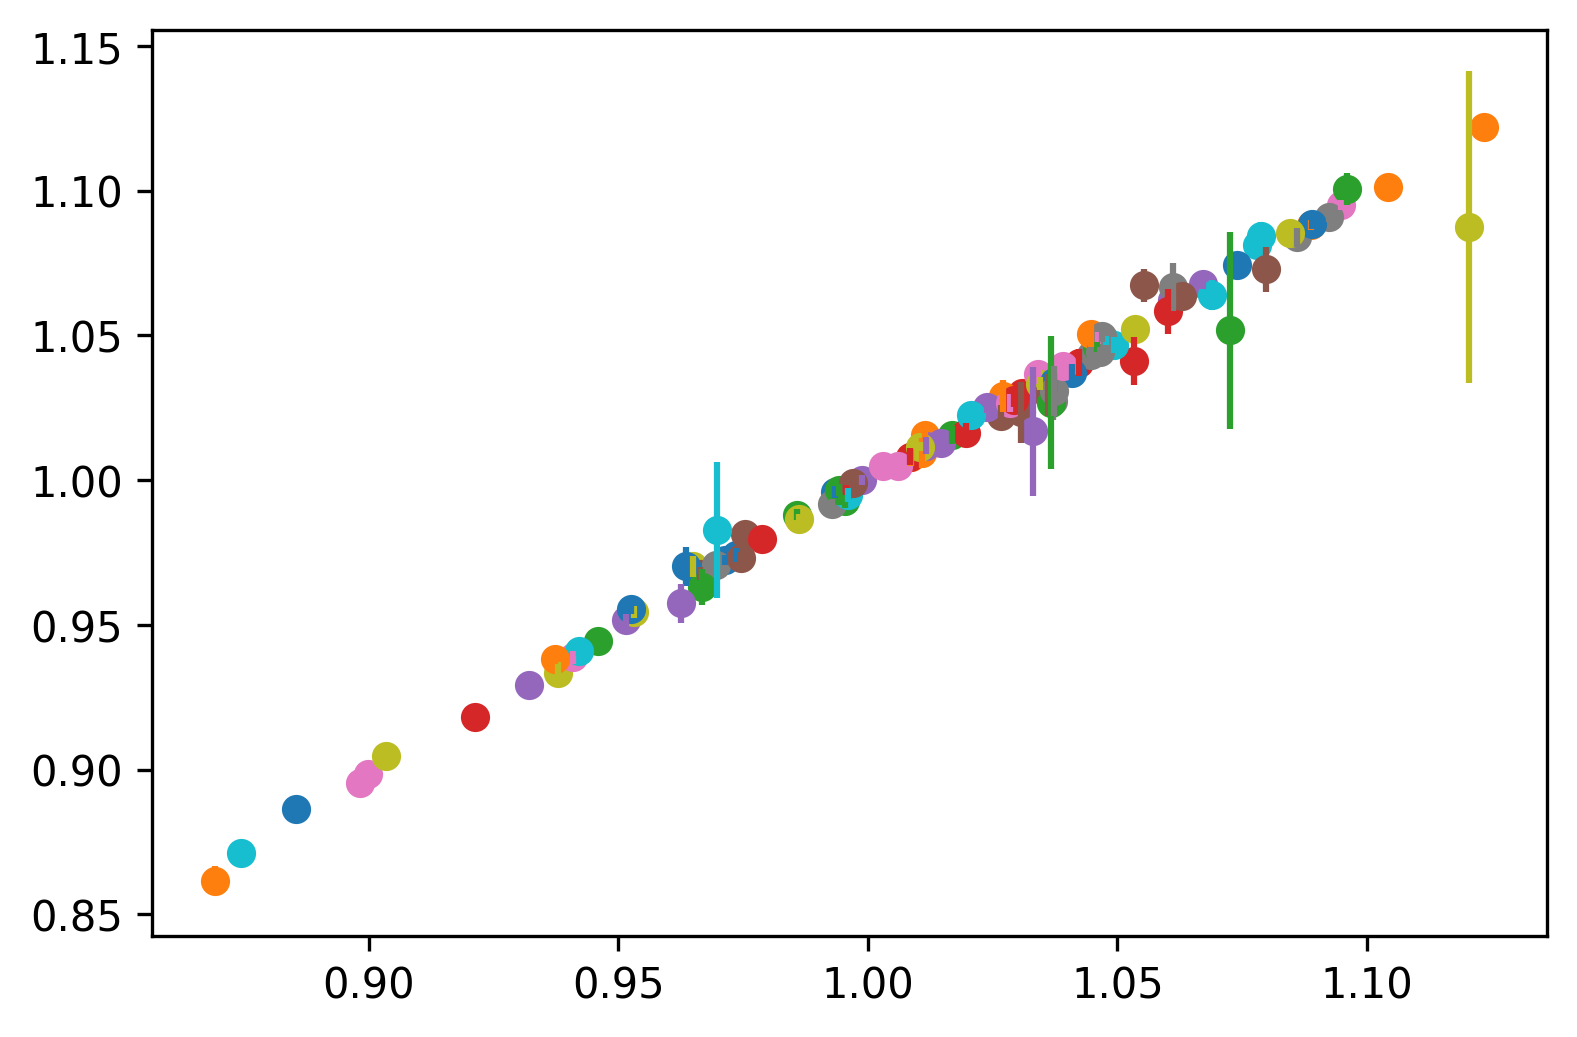

In [54]:
fig, ax = plt.subplots(dpi=300)
for idx, i in enumerate(masses):
    print(i, np.mean(trace['mass'][:, idx]))
    ax.scatter(i, np.mean(trace['mass'][:, idx]))
    ax.errorbar(i, np.mean(trace['mass'][:, idx]), yerr=np.std(trace['mass'][:, idx]))